In [262]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nengo
import sspspace
from uniform_encoders import *

In [2]:
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white')

# Direct neurons, regression decoding

In [3]:
# Fix random seed
seed = 0
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
T = 1  # period of input cycle

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)

In [4]:
sim = nengo.Simulator(network)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [5]:
x_t = sim.data[p_ssp_node]
y_t = sim.data[p_raw_node]
y2_t = np.square(y_t[:,0])
W_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y_t)
W2_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y2_t)
W = W_T.T
W2 = W2_T.T
y_pred = (W @ x_t.T).T
y2_pred = (W2 @ x_t.T).T

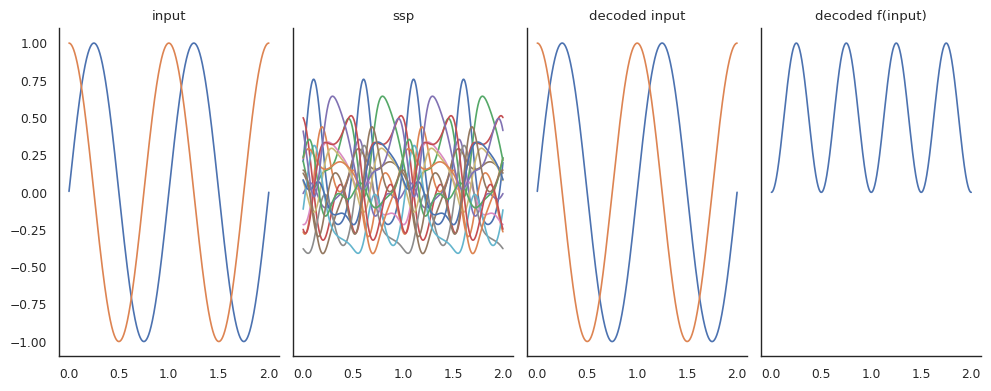

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), y_pred)
axes[3].plot(sim.trange(), y2_pred)
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='decoded input')
axes[3].set(title='decoded f(input)')
sns.despine()
plt.tight_layout()

# LIF neurons, regression decoding

In [7]:
# Fix random seed
seed = 0
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
T = 1  # period of input cycle

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=2000, dimensions=ssp_dim)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_ssp_neurons = nengo.Probe(loc_ssp.neurons, synapse=0.01)

In [8]:
sim = nengo.Simulator(network)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [9]:
x_t = sim.data[p_ssp]
a_t = sim.data[p_ssp]
y_t = sim.data[p_raw_node]
W_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y_t)
Wa_T, residuals, rank, s = scipy.linalg.lstsq(a_t, y_t)
W = W_T.T
Wa = Wa_T.T
y_pred = (W @ x_t.T).T
ya_pred = (Wa @ a_t.T).T

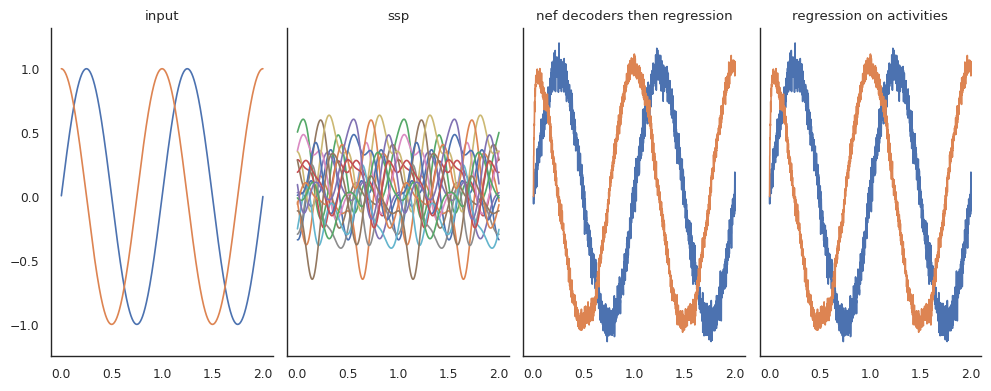

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), y_pred)
axes[3].plot(sim.trange(), ya_pred)
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='nef decoders then regression')
axes[3].set(title='regression on activities')
sns.despine()
plt.tight_layout()

# uniform encoders

In [121]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
T = 1  # period of input cycle

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# neural parameters for SSP population
ssp_neurons = 1000
ssp_intercept = 0.2
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_ssp_neurons = nengo.Probe(loc_ssp.neurons, synapse=0.01)

In [122]:
sim = nengo.Simulator(network)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [123]:
x_t = sim.data[p_ssp]
a_t = sim.data[p_ssp]
y_t = sim.data[p_raw_node]
W_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y_t)
Wa_T, residuals, rank, s = scipy.linalg.lstsq(a_t, y_t)
W = W_T.T
Wa = Wa_T.T
y_pred = (W @ x_t.T).T
ya_pred = (Wa @ a_t.T).T

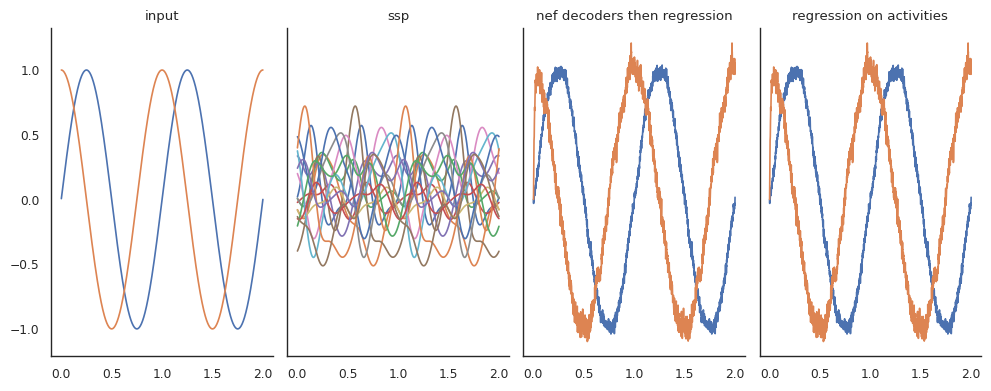

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), y_pred)
axes[3].plot(sim.trange(), ya_pred)
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='nef decoders then regression')
axes[3].set(title='regression on activities')
sns.despine()
plt.tight_layout()

# online learning to decode

In [160]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
P = 1  # period of input cycle
T = 20*P
E = 15*P

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# neural parameters for SSP population
ssp_neurons = 1000
ssp_intercept = 0.3
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)
error_neurons = 1000

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/P), np.cos(2*np.pi*t/P)]
ssp_encode_func = lambda x: loc_space.encode(x)

# computed function
target_func = lambda x: x
null_func = lambda x: [0,0]

# error-driven learning rule
pes = nengo.PES(learning_rate=3e-3)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    output = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=2)
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_raw_node, target, synapse=0.01, function=target_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)
    a = nengo.Connection(loc_ssp, output, synapse=0.01, function=null_func, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=0.01, transform=-1)
    nengo.Connection(target, error, synapse=0.01, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=0.01, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)

In [161]:
sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T)

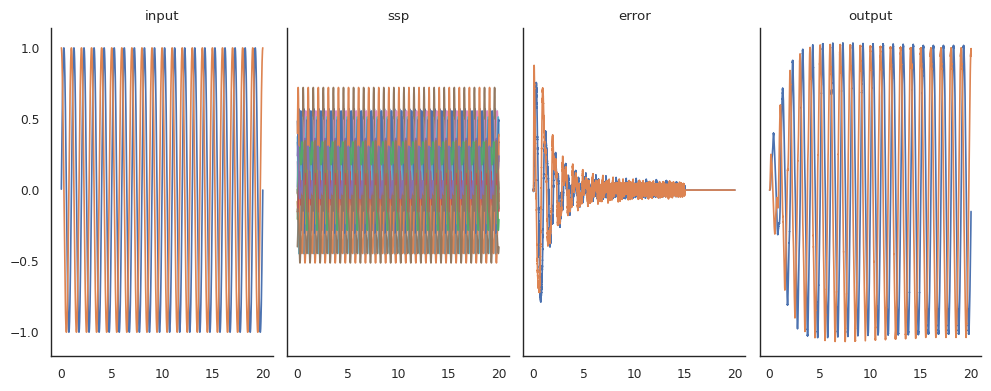

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), sim.data[p_error])
axes[3].plot(sim.trange(), sim.data[p_output])
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='error')
axes[3].set(title='output')
sns.despine()
plt.tight_layout()

# decode a reward function

In [195]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
P = 1  # period of input cycle
T = 12*P
E = 10*P

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# neural parameters for SSP population
ssp_neurons = 1000
ssp_intercept = 0.3
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)
error_neurons = 1000

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/P), np.cos(2*np.pi*t/P)]
ssp_encode_func = lambda x: loc_space.encode(x)
# target_func = lambda x: x[0] + x[1]
target_func = lambda x: np.arctan2(x[1], x[0]) / np.pi

# error-driven learning rule
pes = nengo.PES(learning_rate=3e-3)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_raw_node, target, synapse=0.01, function=target_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)
    a = nengo.Connection(loc_ssp, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=0.01, transform=-1)
    nengo.Connection(target, error, synapse=0.01, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=0.01, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)

In [196]:
sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T)

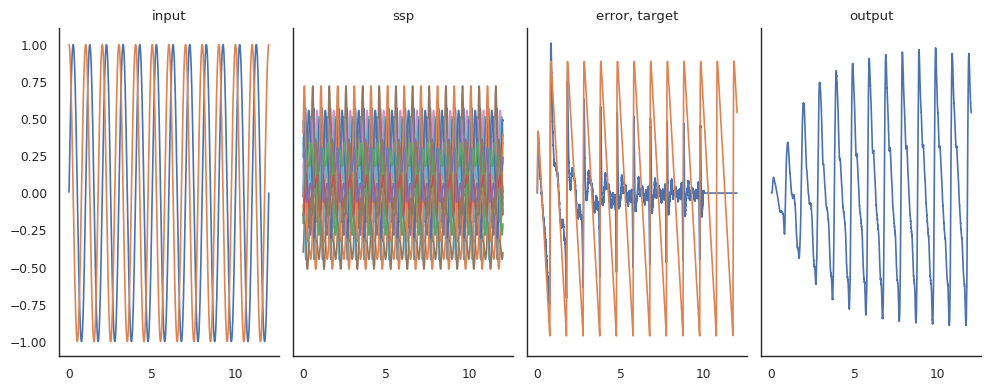

In [197]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), sim.data[p_error])
axes[2].plot(sim.trange(), sim.data[p_target])
axes[3].plot(sim.trange(), sim.data[p_output])
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='error, target')
axes[3].set(title='output')
sns.despine()
plt.tight_layout()

# 3 features, block presentation, linear reward function

In [336]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

ssp_dim = 32  # SSP dimension
length_scale = 1  # lengthscale hypeparameter  - needs to be tuned
P = 1  # trial time
T = 200*P  # total time
E = 180*P  # training time

# Initialize SSP space
ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
ssp_space.update_lengthscale([length_scale, length_scale, length_scale])

# dynamic input to the network
value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
objects = []
values = []
for trial in range(int(T/P)):
    features = rng.uniform(-1,1,size=3)
    object_ssp = ssp_space.encode(features)
    objects.append(object_ssp)
    value = value_func(features)
    values.append(value)

# dynamic input to the network
input_func = lambda t: objects[int(t/P)].flatten()
target_func = lambda t: values[int(t/P)].flatten()

# neural parameters for SSP population
ssp_neurons = 2000
ssp_intercept = 0.3
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)
error_neurons = 200

# error-driven learning rule
pes = nengo.PES(learning_rate=1e-3)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    inpt_ssp = nengo.Node(input_func)
    inpt_target = nengo.Node(target_func)
    state = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(inpt_ssp, state, synapse=None)
    nengo.Connection(inpt_target, target, synapse=0.01)
    a = nengo.Connection(state, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=None, transform=-1)
    nengo.Connection(target, error, synapse=None, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=None, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
    nengo.Connection(output, temp[0], synapse=None)
    nengo.Connection(target, temp[1], synapse=None)
    nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))

    p_state = nengo.Probe(state, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)
    p_reward = nengo.Probe(reward, synapse=0.01)

In [337]:
sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

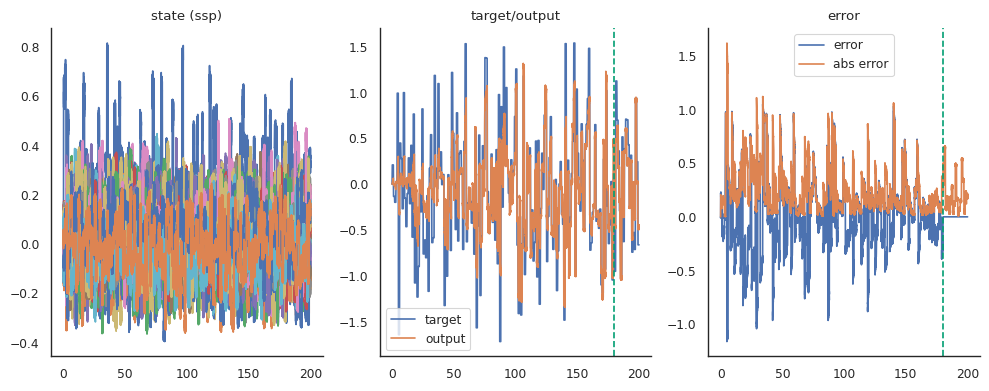

In [338]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_state])
axes[1].plot(sim.trange(), sim.data[p_target], label='target')
axes[1].plot(sim.trange(), sim.data[p_output], label='output')
axes[2].plot(sim.trange(), sim.data[p_error], label='error')
axes[2].plot(sim.trange(), sim.data[p_reward], label='abs error')
axes[1].axvline(E, color=palette[2], linestyle='--')
axes[2].axvline(E, color=palette[2], linestyle='--')
axes[0].set(title='state (ssp)')
axes[1].set(title='target/output')
axes[2].set(title='error')
axes[1].legend()
axes[2].legend()
sns.despine()
plt.tight_layout()

# Train and test multiple subjects

In [339]:
def train_test_subject(seed):
    np.random.seed(seed)
    rng = np.random.RandomState(seed=seed)
    
    ssp_dim = 32  # SSP dimension
    length_scale = 1  # lengthscale hypeparameter  - needs to be tuned
    P = 1  # trial time
    T = 200*P  # total time
    E = 180*P  # training time
    
    # Initialize SSP space
    ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
    ssp_space.update_lengthscale([length_scale, length_scale, length_scale])
    
    # dynamic input to the network
    value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
    objects = []
    values = []
    for trial in range(int(T/P)):
        features = rng.uniform(-1,1,size=3)
        object_ssp = ssp_space.encode(features)
        objects.append(object_ssp)
        value = value_func(features)
        values.append(value)
    
    # dynamic input to the network
    input_func = lambda t: objects[int(t/P)].flatten()
    target_func = lambda t: values[int(t/P)].flatten()
    
    # neural parameters for SSP population
    ssp_neurons = 2000
    ssp_intercept = 0.3
    ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
    ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)
    error_neurons = 200
    
    # error-driven learning rule
    pes = nengo.PES(learning_rate=2e-3)
    
    # nengo Network
    network = nengo.Network(seed=seed)
    with network:
        inpt_ssp = nengo.Node(input_func)
        inpt_target = nengo.Node(target_func)
        state = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                                encoders=ssp_encoders, intercepts=ssp_intercepts)
        output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
        temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
        reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        stop = nengo.Node(lambda t: -1000 if t>E else 0)
        
        nengo.Connection(inpt_ssp, state, synapse=None)
        nengo.Connection(inpt_target, target, synapse=0.01)
        a = nengo.Connection(state, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes)
        nengo.Connection(output, error, synapse=None, transform=-1)
        nengo.Connection(target, error, synapse=None, transform=1)
        nengo.Connection(error, a.learning_rule, synapse=None, transform=-1)
        nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
        nengo.Connection(output, temp[0], synapse=None)
        nengo.Connection(target, temp[1], synapse=None)
        nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))
    
        p_state = nengo.Probe(state, synapse=0.01)
        p_output = nengo.Probe(output, synapse=0.01)
        p_target = nengo.Probe(target, synapse=0.01)
        p_error = nengo.Probe(error, synapse=0.01)
        p_reward = nengo.Probe(reward, synapse=0.01)

    sim = nengo.Simulator(network, progress_bar=False)
    with sim:
        sim.run(T-0.001)

    dfs = []
    columns = ['subject', 'error', 'trial', 'phase']
    for trial in range(1, int(E/P)):  # training 
        error = sim.data[p_reward][int(trial*P/0.001)][0]
        dfs.append(pd.DataFrame([[seed, error, trial, 'train']], columns=columns))
    for trial in range(int(E/P), int(T/P)):  # testing
        error = sim.data[p_reward][int(trial*P/0.001)][0]
        dfs.append(pd.DataFrame([[seed, error, trial, 'test']], columns=columns))

    data = pd.concat(dfs, ignore_index=True)
    return data

In [342]:
dfs = []
for seed in range(100):
    print(f'training subject {seed}')
    dfs.append(train_test_subject(seed=seed))
data = pd.concat(dfs, ignore_index=True)

training subject 0
training subject 1
training subject 2
training subject 3
training subject 4
training subject 5
training subject 6
training subject 7
training subject 8
training subject 9
training subject 10
training subject 11
training subject 12
training subject 13
training subject 14
training subject 15
training subject 16
training subject 17
training subject 18
training subject 19
training subject 20
training subject 21
training subject 22
training subject 23
training subject 24
training subject 25
training subject 26
training subject 27
training subject 28
training subject 29
training subject 30
training subject 31
training subject 32
training subject 33
training subject 34
training subject 35
training subject 36
training subject 37
training subject 38
training subject 39
training subject 40
training subject 41
training subject 42
training subject 43
training subject 44
training subject 45
training subject 46
training subject 47
training subject 48
training subject 49
training s

<Axes: ylabel='error'>

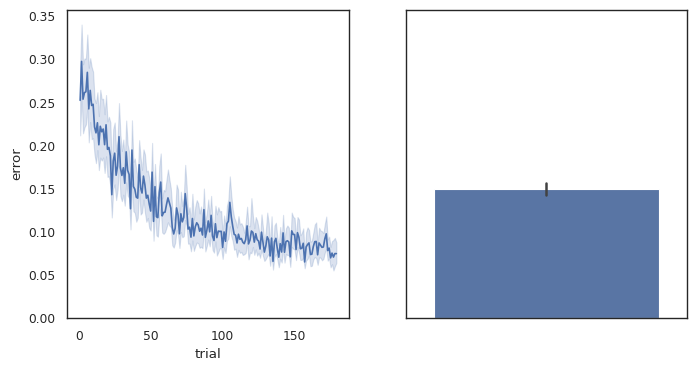

In [343]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))
sns.lineplot(data.query("phase=='train'"), x='trial', y='error', ax=axes[0])
# sns.violinplot(data.query("phase=='test'"),  y='error', ax=axes[1])
sns.barplot(data.query("phase=='test'"),  y='error', ax=axes[1])